In [1]:
import torch
import torch.nn as nn
import numpy as np
import traci
import matplotlib.pyplot as plt

from helper_functions import get_nearest_vehicle_distance, update_live_plot


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


# Parameters

In [2]:
# Simulation parameters
SUMO_BINARY = "sumo"  # or "sumo-gui"
SUMO_CONFIG = "../config/my_simulation.sumocfg"
SIMULATION_STEPS = 10000

# Define state and action space sizes
STATE_SIZE = 6
ACTION_SIZE = 2
BATCH_SIZE = 32

# Model Loading

In [3]:
# Recreate the same model architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size, batch_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, batch_size)
        self.fc2 = nn.Linear(batch_size, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# # Initialize the policy network
model = DQN(STATE_SIZE, ACTION_SIZE, BATCH_SIZE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "saved_models/dqn_model.pth"  # Path to your saved model

# Load Model
model = torch.load(model_path, map_location=DEVICE)
model.eval()  # Evaluation mode (for inference)

DQN(
  (fc1): Linear(in_features=6, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

# MDP

#### State space

In [5]:
def get_state():
    """Retrieve the current state from SUMO."""

    # Cars density
    highway_density = traci.edge.getLastStepVehicleNumber("E6")

    # Cars speed
    highway_speed = traci.edge.getLastStepMeanSpeed("E6")
    ramp_speed = traci.edge.getLastStepMeanSpeed("E8")
    
    # Halting cars
    highway_halts = traci.edge.getLastStepHaltingNumber("E6")
    ramp_halts = traci.edge.getLastStepHaltingNumber("E8")

    # Nearest Distance from highway to TL
    nearest_distance_highway = get_nearest_vehicle_distance("J11", "E6")
    

    state = [
        highway_density,
        highway_speed,
        ramp_speed,
        highway_halts,
        ramp_halts,
        nearest_distance_highway
    ]
    
    return state


#### Reward function

In [6]:
def calculate_reward(state):
    """Calculate reward based on the current state."""

    highway_speed = state[1]
    ramp_speed = state[2]
    highway_halts = state[3]
    ramp_halts = state[4]

    ramp_density = traci.edge.getLastStepVehicleNumber("E8")
    nbr_stopping_vehicles = traci.simulation.getEmergencyStoppingVehiclesNumber()       # Emergency stopping cars
    nbr_colliding_vehicles = traci.simulation.getCollidingVehiclesNumber()              # Collisions (accidents)


    reward = - (highway_halts + ramp_halts + ramp_density + nbr_stopping_vehicles) + (highway_speed + ramp_speed) * 0.1 - nbr_colliding_vehicles * 10
    
    return reward

#### Action space

In [7]:
def choose_action(state):
    """Choose action using the trained policy network."""
    state_tensor = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    with torch.no_grad():       # No gradient computation for inference
        action = model(state_tensor).argmax(dim=1).item()  # Get the best action
    return action


def take_action(action):
    """Apply the selected action in SUMO."""
    traci.trafficlight.setPhase("J11", action)

# Inference

In [8]:
UPDATE_PLOT_FREQ = 10           # update the plot every 10 steps

def run_inference():
    """Run SUMO simulation with the trained DQN model."""
    traci.start([SUMO_BINARY, "-c", SUMO_CONFIG])
    
    # Initialize the runtime plot
    plt.ion()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title("Reward per Step")
    ax.set_xlabel("Step")
    ax.set_ylabel("Reward")
    line, = ax.plot([], [], label="Reward", color='blue')
    ax.legend()

    # Init
    state = get_state()
    rewards_per_step = []

    # Main inference loop
    for step in range(SIMULATION_STEPS):
        # Get and Execute action A
        action = choose_action(state)
        take_action(action)
        traci.simulationStep()      # Advance the simulation by one step

        # Observe the next state S' and the immediate reward R
        next_state = get_state()
        reward = calculate_reward(next_state)

        rewards_per_step.append(reward)

        # Update the plot
        if step % UPDATE_PLOT_FREQ == 0 or step == SIMULATION_STEPS - 1:
            update_live_plot(fig, ax, line, rewards_per_step)

        state = next_state
        
    
    traci.close()

    # Finalize the plot
    plt.ioff()
    plt.show()

    return rewards_per_step
    

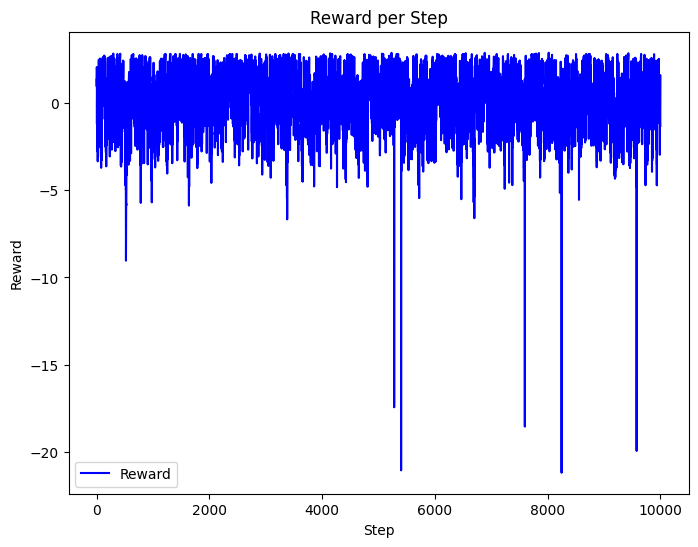

In [9]:
# Run the inference
dqn_rewards = run_inference()